In [3]:
pip install imblearn

     |████████████████████████████████| 189 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 7.9 MB 12.7 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install delayed

     |████████████████████████████████| 118 kB 5.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [168]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, 
                             accuracy_score, precision_score, recall_score, f1_score, auc, 
                             precision_recall_curve, average_precision_score)
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_rows', 500)

In [169]:
#Loading the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
weather = pd.read_csv('Cleaned_weather.csv')
ftrain = pd.read_csv('Final_train.csv')
ftest = pd.read_csv('Final_test.csv')

In [170]:
test_id = test['Id']

TRAIN AND TEST SPLIT

In [171]:
ftrain = ftrain.drop(columns=['Year', 'Sunrise_WeekAvgTemp', 'DewPoint_Sunrise', 'Depart_WeekPrecipTotal'])
ftest = ftest.drop(columns=['Year', 'Sunrise_WeekAvgTemp', 'DewPoint_Sunrise', 'Depart_WeekPrecipTotal'])

In [172]:
X = ftrain
y = train['WnvPresent']

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

BASELINE MODEL

In [199]:
# Baseline
y = train['WnvPresent']
y.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

MODEL PREPARATION

In [200]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rfc': RandomForestClassifier(random_state=42),
        }

In [209]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    results['accuracy'] = accuracy_score(y_test, predictions)
    results['Matrix'] = confusion_matrix(y_test, predictions)
    class_names=[0,1] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(results['Matrix']), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

TESTING MODELS WITHOUT FEATURE ENGINEERING

LOGISTIC REGRESSION

### METRICS ###


{'model': 'lr',
 'train_auc': 0.8487921473233058,
 'test_auc': 0.8046250925728662,
 'precision': 0.13143483023001096,
 'specificity': 0.7345162370271175,
 'recall': 0.7272727272727273,
 'f_score': 0.22263450834879406,
 'accuracy': 0.7341370558375635,
 'Matrix': array([[2194,  793],
        [  45,  120]])}

True Negatives: 2194
False Positives: 793
False Negatives: 45
True Positives: 120


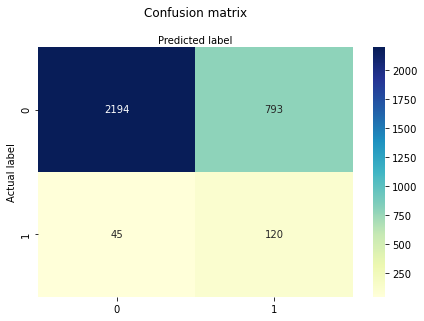

In [210]:
lr = run_model('lr')

RANDOM FOREST CLASSIFIER

### METRICS ###


{'model': 'rfc',
 'train_auc': 0.9966787341608218,
 'test_auc': 0.7727546641507137,
 'precision': 0.18670886075949367,
 'specificity': 0.9139604954804151,
 'recall': 0.3575757575757576,
 'f_score': 0.24532224532224534,
 'accuracy': 0.8848350253807107,
 'Matrix': array([[2730,  257],
        [ 106,   59]])}

True Negatives: 2730
False Positives: 257
False Negatives: 106
True Positives: 59


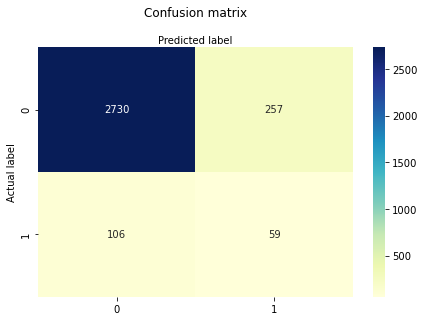

In [211]:
rfc = run_model('rfc')

In [212]:
# Results of our initial modelling
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,precision,specificity,recall,f_score,accuracy,Matrix
0,lr,0.848792,0.804625,0.131435,0.734516,0.727273,0.222635,0.734137,"[[2194, 793], [45, 120]]"
1,rfc,0.996679,0.772755,0.186709,0.913960,0.357576,0.245322,0.884835,"[[2730, 257], [106, 59]]"


AUC-ROC EVALUATION

In [213]:
init_dict = {
    lr: 'LogisticRegression',
    rfc: 'RandomForestClassifier'
}

In [214]:
#Function to plot the AUC-ROC curve

def auc_roc_curve(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

/Users/vim/anaconda3/envs/vpwebscraping/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/vim/anaconda3/envs/vpwebscraping/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


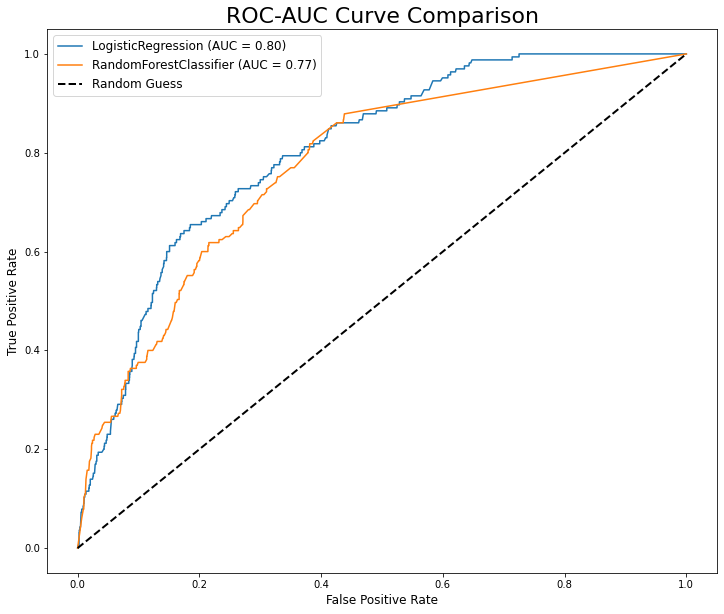

In [215]:
#Applying the function 
auc_roc_curve(init_dict)

HYPERPARAMETER TUNING WITH SMOTE

In [216]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

LOGISTIC REGRESSION

In [217]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1', 'elasticnet'],

     # Trying different alphas of: 1, 0.1, 0.05  (C = 1/alpha)
    'lr__C':[1, 10, 20],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/Users/vim/anaconda3/envs/vpwebscraping/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/vim/anaconda3/envs/vpwebscraping/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vim/anaconda3/envs/vpwebscraping/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/vim/anaconda3/envs/vpwebscraping/lib/python3.8/site-packages/sklearn/li

### BEST PARAMS ###


{'lr__C': 10, 'lr__penalty': 'l2'}

### METRICS ###


{'model': 'lr',
 'train_auc': 0.8488675700199436,
 'test_auc': 0.8037505960170841,
 'precision': 0.1319290465631929,
 'specificity': 0.7378640776699029,
 'recall': 0.7212121212121212,
 'f_score': 0.22305529522024367,
 'accuracy': 0.736992385786802,
 'Matrix': array([[2204,  783],
        [  46,  119]])}

True Negatives: 2204
False Positives: 783
False Negatives: 46
True Positives: 119


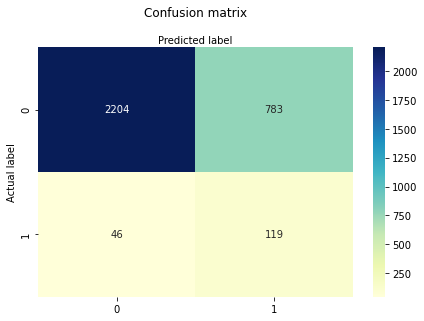

In [218]:
lr_gs = run_model('lr', mod_params=lr_params, grid_search=True)

RANDOM FOREST CLASSIFIER

In [219]:
rfc_params = {'rfc__n_estimators': [20, 25, 30, 35],
             'rfc__max_depth': [20, 30, 40, 50],
             'rfc__min_samples_leaf': [2, 3, 4],
            }

Fitting 3 folds for each of 48 candidates, totalling 144 fits
### BEST PARAMS ###


{'rfc__max_depth': 30, 'rfc__min_samples_leaf': 2, 'rfc__n_estimators': 35}

### METRICS ###


{'model': 'rfc',
 'train_auc': 0.9915282207757028,
 'test_auc': 0.7963143318014425,
 'precision': 0.16990291262135923,
 'specificity': 0.8855038500167393,
 'recall': 0.42424242424242425,
 'f_score': 0.24263431542461006,
 'accuracy': 0.8613578680203046,
 'Matrix': array([[2645,  342],
        [  95,   70]])}

True Negatives: 2645
False Positives: 342
False Negatives: 95
True Positives: 70


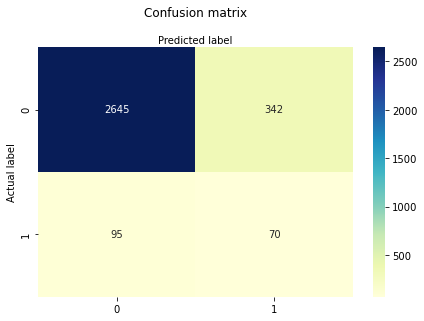

In [220]:
rfc_gs =  run_model('rfc', mod_params=rfc_params, grid_search=True)

In [221]:
gs_df = pd.DataFrame(gs_list)
gs_df.sort_values(by='test_auc', ascending=False)

,model,train_auc,test_auc,precision,specificity,recall,f_score,accuracy,Matrix
0,lr,0.848868,0.803751,0.131929,0.737864,0.721212,0.223055,0.736992,"[[2204, 783], [46, 119]]"
1,rfc,0.991528,0.796314,0.169903,0.885504,0.424242,0.242634,0.861358,"[[2645, 342], [95, 70]]"


FINAL AUC-ROC EVALUATION

In [222]:
gs_dict = {
    lr_gs: 'LogisticRegression',
    rfc_gs: 'RandomForestClassifier'
}

/Users/vim/anaconda3/envs/vpwebscraping/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/vim/anaconda3/envs/vpwebscraping/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


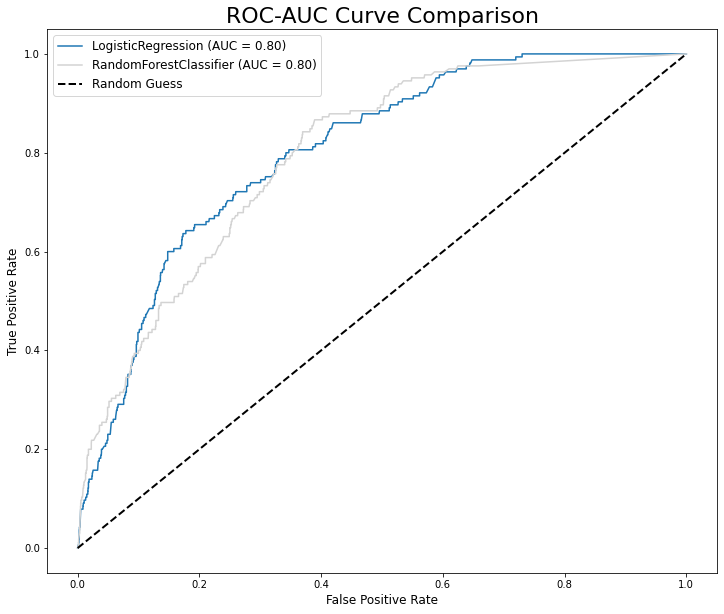

In [223]:
auc_roc_curve(gs_dict, plot_top=True)

In [258]:
# Refit model on training data
final_model = rfc_gs.fit(X, y)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


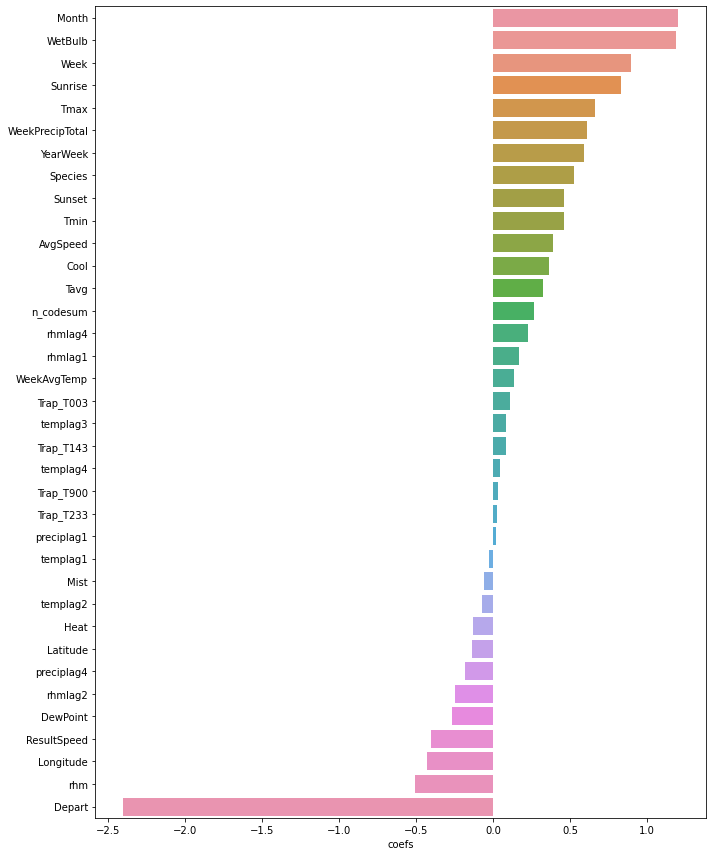

In [236]:
lr_gs_df = pd.DataFrame(columns=X.columns, data=lr_gs.best_estimator_.steps[1][1].coef_).T
lr_gs_df.columns = ['coefs']
lr_gs_df = lr_gs_df.sort_values(ascending=False, by='coefs')
plt.figure(figsize=(10, 12))
sns.barplot(data=lr_gs_df, y=lr_gs_df.index, x='coefs', orient='h')
plt.tight_layout()
plt.savefig(fname='final_model_lr', dpi=300)

In [259]:
predictions = final_model.predict(ftest)

In [260]:
df = pd.DataFrame(predictions)
df[0].value_counts()

0    116293
Name: 0, dtype: int64

In [261]:
prediction = final_model.predict_proba(ftest)

In [262]:
probability = [i[1] for i in prediction]

In [263]:
# Saving final model for further analysis
filename = 'Final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

PREDICTION RESULTS

In [264]:
result = pd.DataFrame()
result['Id'] = test_id
result['WnvPresent'] = probability
result

,Id,WnvPresent
0,1,0.003333
1,2,0.000000
2,3,0.003333
3,4,0.000000
4,5,0.000000
...,...,...
116288,116289,0.062906
116289,116290,0.062906
116290,116291,0.062906
116291,116292,0.062906


In [265]:
test['Date'] = pd.to_datetime(test['Date'])
test['Year'] = test['Date'].apply(lambda x: x.year)

In [266]:
result['Year'] = test['Year']

In [267]:

def year_mod(row):
    if row['Year'] == 2012:
        row['WnvPresent'] = row['WnvPresent'] * 2
        if row['WnvPresent'] > 1:
            row['WnvPresent'] = 0.99
    return row

In [268]:
result = result.apply(year_mod, axis=1)

In [269]:
result['Id'] = result['Id'].astype(int)
result = result.drop(columns='Year')

Export to CSV


In [270]:
result.to_csv('FinalOutput.csv', index=False)

In [271]:
op = pd.read_csv('FinalOutput.csv')

In [272]:
op.head()

,Id,WnvPresent
0,1,0.003333
1,2,0.000000
2,3,0.003333
3,4,0.000000
4,5,0.000000


In [273]:
op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          116293 non-null  int64  
 1   WnvPresent  116293 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.8 MB
